In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import logging
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [16]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

In [17]:
def create_spark_session(app_name="Flight Delay Prediction"):
    """
    This function sets up a Spark session, which is the starting point for working with Spark.
    Spark is a software tool that can help us analyze and process large amounts of data.
    """
    logging.info("Creating Spark session...")
    spark = SparkSession.builder \
        .appName(app_name) \
        .getOrCreate()
    logging.info("Spark session created.")
    return spark

In [18]:
def load_data(spark, data_path):
    """
    This function reads the Airlines dataset from the specified file path and returns it as a Spark DataFrame.
    A Spark DataFrame is like a spreadsheet, where each row represents a flight and each column represents a piece of information about that flight.
    """
    logging.info("Loading data from path: %s", data_path)
    df = spark.read.csv(data_path, header=True, inferSchema=True)
    logging.info("Data loaded.")
    return df

In [19]:
def clean_data(df):
    """
    This function cleans the dataset by removing any duplicate flights and filling in any missing information.
    Cleaning the data helps to ensure that the machine learning model we build later on will work as well as possible.
    """
    logging.info("Cleaning the data...")
    df = df.dropDuplicates().na.drop()
    logging.info("Data cleaning completed.")
    return df

In [20]:
def encode_categorical_variables(df):
    """
    This function takes the dataset and converts the airline, origin airport, and destination airport information from text into numbers.
    This is necessary because machine learning models work better with numbers than with text.
    """
    logging.info("Encoding categorical variables...")
    indexers = [StringIndexer(inputCol=col, outputCol=col+"_Indexed").fit(df) for col in ["Airline", "AirportFrom", "AirportTo"]]
    for indexer in indexers:
        df = indexer.transform(df)
    logging.info("Categorical variables encoded.")
    return df

In [21]:
def assemble_features(df, input_cols, output_col):
    """
    This function takes the different pieces of information about each flight (like the day of the week, departure time, and flight duration) and combines them into a single column called "features".
    The machine learning model will use this "features" column to predict whether a flight will be delayed or not.
    """
    logging.info("Assembling features...")
    assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col)
    df = assembler.transform(df)
    logging.info("Features assembled.")
    return df

In [22]:
def split_data(df, train_ratio=0.8, seed=1234):
    """
    This function splits the dataset into two parts: a "training" set and a "testing" set.
    The training set will be used to build the machine learning model, and the testing set will be used to check how well the model works.
    """
    logging.info("Splitting data into training and testing sets...")
    train_data, test_data = df.randomSplit([train_ratio, 1-train_ratio], seed=seed)
    logging.info("Data split completed.")
    return train_data, test_data

In [23]:
def train_and_evaluate_models(train_data, test_data):
    """
    Train and evaluate multiple machine learning models and return their performance metrics.
    This function now includes evaluation of accuracy, precision, recall, and F1-score alongside AUC.
    """
    logging.info("Training and evaluating models...")
    models = {
        "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="Delay"),
        "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="Delay", maxBins=300),
        "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="Delay", maxBins=300),
        "Gradient Boosting": GBTClassifier(featuresCol="features", labelCol="Delay", maxBins=300)
    }

    trained_models = {}
    results = {}
    for name, model in models.items():
        logging.info(f"Training {name}...")
        trained_model = model.fit(train_data)
        predictions = trained_model.transform(test_data)

        logging.info(f"Evaluating {name}...")
        # Evaluators for different metrics
        evaluator_auc = BinaryClassificationEvaluator(labelCol="Delay", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        evaluator_acc = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction", metricName="accuracy")
        evaluator_precision = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction", metricName="weightedPrecision")
        evaluator_recall = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction", metricName="weightedRecall")
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Delay", predictionCol="prediction", metricName="f1")

        # Calculating metrics
        auc = evaluator_auc.evaluate(predictions)
        accuracy = evaluator_acc.evaluate(predictions)
        precision = evaluator_precision.evaluate(predictions)
        recall = evaluator_recall.evaluate(predictions)
        f1 = evaluator_f1.evaluate(predictions)

        results[name] = {
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

        trained_models[name] = trained_model
        logging.info(f"{name} - AUC: {auc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

    return results, trained_models

In [24]:
def plot_roc_curves(test_data, models):
    """
    Plot ROC curves for each trained model to visualize their performance.
    """
    plt.figure(figsize=(10, 6))
    for name, model_info in models.items():
        logging.info(f"Plotting ROC curve for {name}...")
        predictions = model_info.transform(test_data)  # Ensure model_info is the model and not another dictionary or DataFrame
        preds_and_labels = predictions.select(['probability', 'Delay']).toPandas()
        preds_and_labels['probability'] = preds_and_labels['probability'].apply(lambda x: x[1])

        fpr, tpr, _ = roc_curve(preds_and_labels['Delay'], preds_and_labels['probability'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
def plot_evaluation_metrics(results):
    """
    This function plots a bar chart for the evaluation metrics of each model.
    It visualizes accuracy, precision, recall, F1-score, and AUC.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Metrics to plot
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
    # Colors for different models
    colors = ['blue', 'green', 'red', 'purple']

    # Set up the matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(14, 8))
    n_groups = len(results)
    index = np.arange(n_groups)
    bar_width = 0.1
    opacity = 0.8

    # Loop through each metric and create a bar for it
    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in results]
        plt.bar(index + i*bar_width, values, bar_width, alpha=opacity, color=colors[i % len(colors)], label=metric)

    plt.xlabel('Model')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Model')
    plt.xticks(index + bar_width, list(results.keys()))
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def plot_confusion_matrix(predictions, title='Confusion Matrix'):
    """
    Plot a confusion matrix for the predictions made by the model.
    """
    # Convert Spark DataFrame to Pandas DataFrame
    y_true = predictions.select("Delay").collect()
    y_pred = predictions.select("prediction").collect()
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    return plt

In [27]:
def main():
    # Create a Spark session
    spark = create_spark_session()

    # Load the Airlines dataset
    data_path = "/workspaces/predict-whether-a-given-flight-will-be-delayed-pyspark/airlines_dataset.csv"  # Update this path as necessary
    df = load_data(spark, data_path)

    # Clean the data
    df = clean_data(df)

    # Encode the categorical variables
    df = encode_categorical_variables(df)

    # Assemble the features
    df = assemble_features(df, input_cols=["DayOfWeek", "Time", "Length", "Airline_Indexed", "AirportFrom_Indexed", "AirportTo_Indexed"], output_col="features")

    # Split the data into training and testing sets
    train_data, test_data = split_data(df)

    # Train and evaluate models
    results, trained_models = train_and_evaluate_models(train_data, test_data)

    # Visualize ROC curves
    plot_roc_curves(test_data, trained_models)  # Ensure trained_models is passed correctly

    # Plot other performance metrics
    plot_evaluation_metrics(results)
    
    # Plot confusion matrix for each model
    for name, model in trained_models.items():
        logging.info(f"Plotting confusion matrix for {name}...")
        predictions = model.transform(test_data)
        plt = plot_confusion_matrix(predictions, title=f'{name} Confusion Matrix')
        plt.show()

2024-04-17 02:14:15 INFO: Creating Spark session...
2024-04-17 02:14:15 INFO: Spark session created.
2024-04-17 02:14:15 INFO: Loading data from path: /workspaces/predict-whether-a-given-flight-will-be-delayed-pyspark/airlines_dataset.csv
2024-04-17 02:14:18 INFO: Data loaded.
2024-04-17 02:14:18 INFO: Cleaning the data...
2024-04-17 02:14:18 INFO: Data cleaning completed.
2024-04-17 02:14:18 INFO: Encoding categorical variables...
2024-04-17 02:14:21 INFO: Categorical variables encoded.
2024-04-17 02:14:21 INFO: Assembling features...
2024-04-17 02:14:21 INFO: Features assembled.
2024-04-17 02:14:21 INFO: Splitting data into training and testing sets...
2024-04-17 02:14:21 INFO: Data split completed.
2024-04-17 02:14:21 INFO: Training and evaluating models...
2024-04-17 02:14:21 INFO: Training Logistic Regression...
24/04/17 02:14:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/17 02:14:23 WARN InstanceBuilder: Failed to load implement

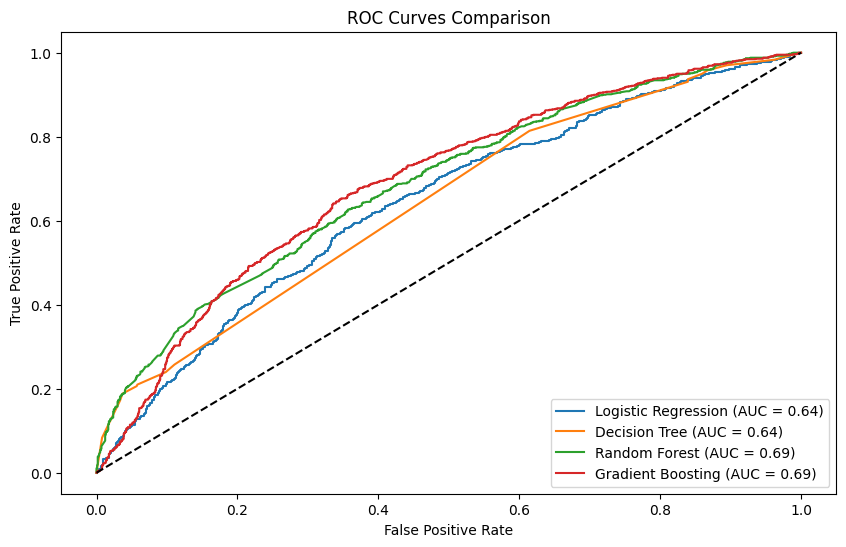

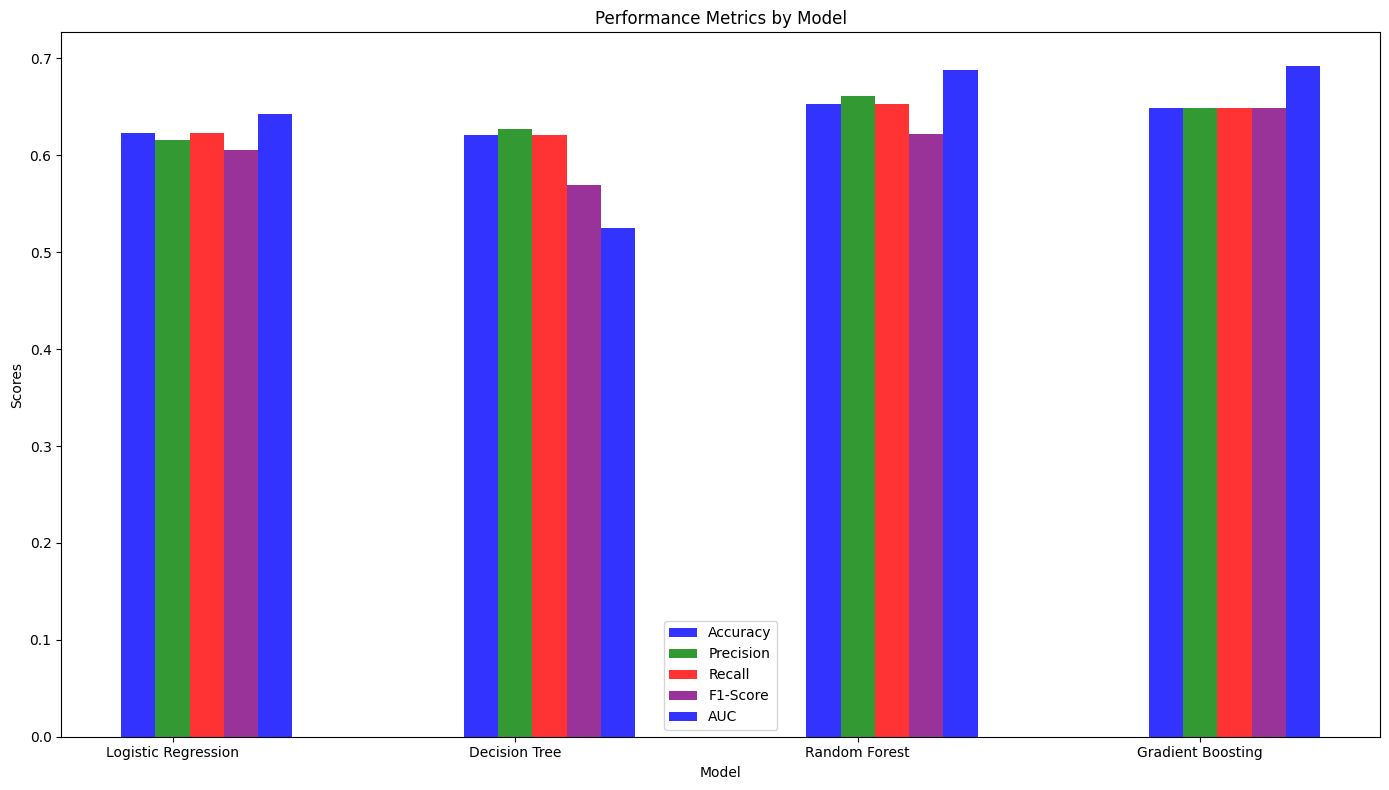

2024-04-17 02:14:44 INFO: Plotting confusion matrix for Logistic Regression...


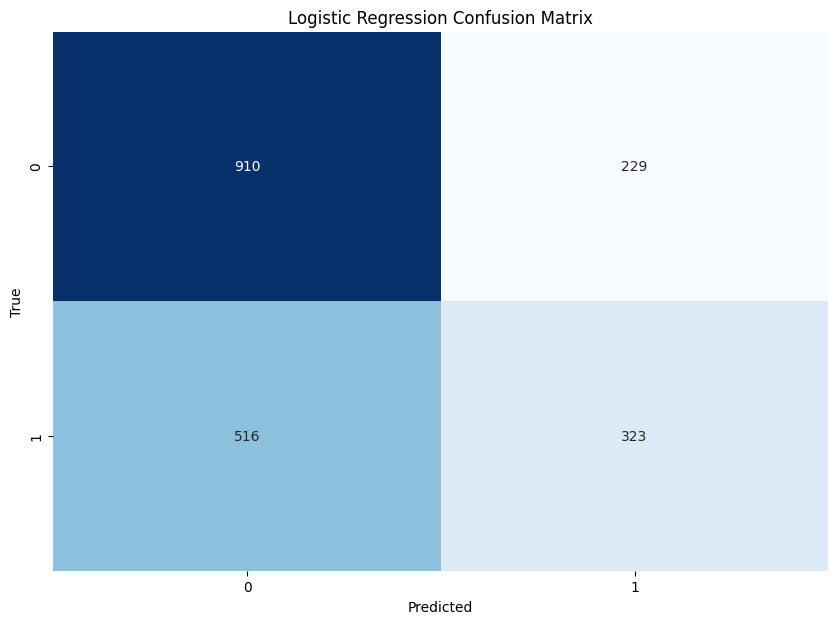

2024-04-17 02:14:45 INFO: Plotting confusion matrix for Decision Tree...


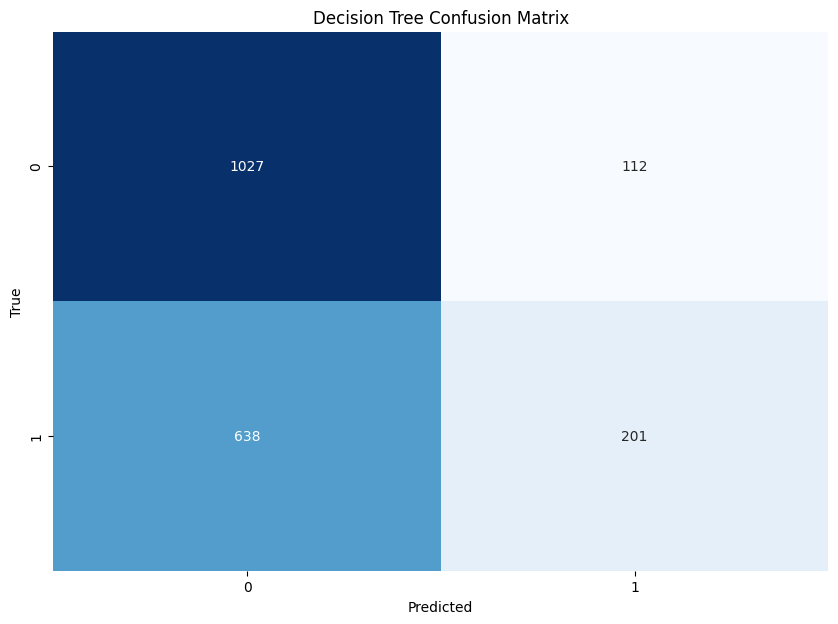

2024-04-17 02:14:45 INFO: Plotting confusion matrix for Random Forest...


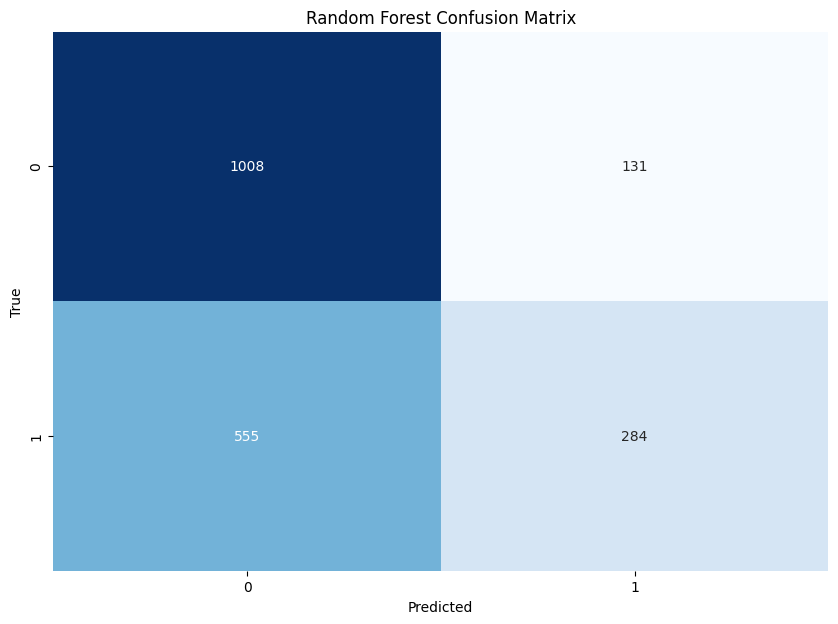

2024-04-17 02:14:46 INFO: Plotting confusion matrix for Gradient Boosting...


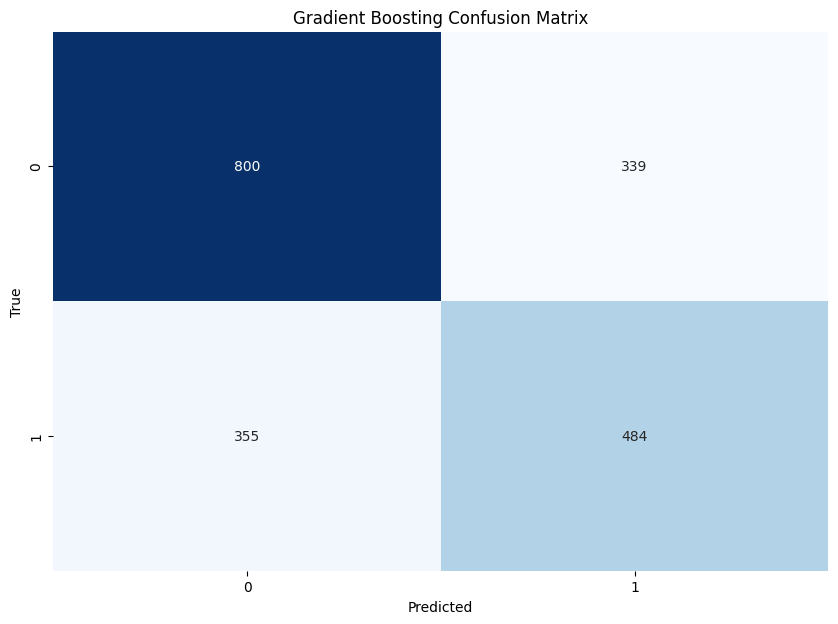

In [28]:
if __name__ == "__main__":
    main()